In [1]:
from pyspark.sql import SparkSession

# Stop the existing Spark session
SparkSession.builder.getOrCreate().stop()

# Start a new Spark session
spark = SparkSession.builder \
    .appName("PCAFromParquet") \
    .getOrCreate()


24/12/07 00:57:36 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
spark



In [13]:
# Load Parquet file
file_path = "/home/ymusic7/metro_restaurants/balanced_reviews.parquet"
df = spark.read.parquet(file_path)

df.show(5, truncate=False)


+---------------------------+------------------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-----+-------------------+---------------------------------------------------

In [50]:
# bag of words
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer

# Tokenize the text column
tokenizer = Tokenizer(inputCol='text', outputCol='words')
df_tokenized = tokenizer.transform(df)

# Remove stopwords
stopwords = StopWordsRemover.loadDefaultStopWords("english")
remover = StopWordsRemover(inputCol='words', outputCol='filtered_words', stopWords=stopwords)
df_filtered = remover.transform(df_tokenized)

# Create Bag-of-Words using CountVectorizer
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
vectorized_model = vectorizer.fit(df_filtered)
df_bow = vectorized_model.transform(df_filtered)

# check Bag-of-Words features
df_bow.select("filtered_words", "features").show(5, truncate=False)


24/12/07 03:19:28 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/07 03:19:28 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------

In [5]:
df_bow.show(5, truncate=False)

24/12/07 01:04:53 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
24/12/07 01:04:53 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
+---------------------------+------------------+------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
# Save Bag-of-Words output to Parquet
output_bow_path = "/home/ymusic7/metro_restaurants/bow_reviews.parquet"
df_bow.write.parquet(output_bow_path)


24/12/07 01:05:38 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("BoW Analysis") \
    .getOrCreate()


24/12/07 01:53:32 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# Load the Parquet file
parquet_path = "/home/ymusic7/metro_restaurants/bow_reviews.parquet"  # Update if necessary
df_bow = spark.read.parquet(parquet_path)

# Display schema to verify the contents
df_bow.printSchema()

# Show sample data
df_bow.show(5, truncate=False)

root
 |-- name: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- text: string (nullable = true)
 |-- date: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- keyword: string (nullable = true)
 |-- addr: string (nullable = true)
 |-- language: string (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)



+---------------------------+------------------+------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------+-----+-------------------+---------------------------------------------------

In [4]:
from pyspark.sql.functions import col, explode, count

# Filter for reviews with negative scores
negative_reviews = df_bow.filter(col("score") <= 2)

# Explode the filtered_words column to analyze word frequencies
negative_words = negative_reviews.select(explode(col("filtered_words")).alias("word"))

# Count the word frequencies
negative_word_freq = negative_words.groupBy("word").count().orderBy(col("count").desc())

# Show the most frequent words in negative reviews
negative_word_freq.show(20, truncate=False)



+-------+-----+
|word   |count|
+-------+-----+
|food   |55718|
|       |49798|
|order  |22318|
|like   |21651|
|ordered|19837|
|place  |19517|
|chicken|19132|
|never  |17056|
|time   |15761|
|rice   |15590|
|service|15420|
|even   |14822|
|get    |14491|
|good   |14418|
|got    |14147|
|one    |13660|
|go     |13202|
|sushi  |12983|
|us     |12797|
|back   |12112|
+-------+-----+
only showing top 20 rows



In [7]:
# n-gram makes more sense
from pyspark.ml.feature import NGram
from pyspark.sql.functions import col, explode

# Generate bigrams (2-grams)
ngram = NGram(n=5, inputCol="filtered_words", outputCol="bigrams")

# Transform the dataset to include bigrams
df_bigrams = ngram.transform(df_bow)

# Filter for negative reviews for Chinese cuisine
negative_chinese_bigrams = df_bigrams.filter((col("score") <= 2) & (col("keyword") == "chinese restaurant"))

# Explode the bigrams column to analyze frequency
negative_chinese_bigram_words = negative_chinese_bigrams.select(explode(col("bigrams")).alias("bigram"))

# Count the bigram frequencies for Chinese cuisine
negative_chinese_bigram_freq = negative_chinese_bigram_words.groupBy("bigram").count().orderBy(col("count").desc())
print("Most frequent bigrams in negative reviews for Chinese cuisine:")
negative_chinese_bigram_freq.show(20, truncate=False)

# Filter for negative reviews for Japanese cuisine
negative_japanese_bigrams = df_bigrams.filter((col("score") <= 2) & (col("keyword") == "japanese restaurant"))

# Explode the bigrams column to analyze frequency
negative_japanese_bigram_words = negative_japanese_bigrams.select(explode(col("bigrams")).alias("bigram"))

# Count the bigram frequencies for Japanese cuisine
negative_japanese_bigram_freq = negative_japanese_bigram_words.groupBy("bigram").count().orderBy(col("count").desc())
print("Most frequent bigrams in negative reviews for Japanese cuisine:")
negative_japanese_bigram_freq.show(20, truncate=False)


Most frequent bigrams in negative reviews for Chinese cuisine:


+----------------------------------+-----+
|bigram                            |count|
+----------------------------------+-----+
|worst chinese food ever had.      |173  |
|                                  |151  |
|worst chinese food i’ve ever      |119  |
|chinese food i’ve ever had.       |67   |
|worst chinese food ever eaten.    |27   |
|chinese food ever had.            |26   |
|far worst chinese food ever       |26   |
|worst chinese food ever life.     |22   |
|worst chinese food ever had,      |18   |
|egg drop soup tasted like         |17   |
|probably worst chinese food ever  |13   |
|worst chinese food ive ever       |13   |
|save money go somewhere else.     |13   |
|sweet sour sauce sweet sour       |12   |
|hot sour soup tasted like         |12   |
|absolutely worst chinese food ever|12   |
|chinese food i’ve ever eaten.     |12   |
|ordered sweet & sour chicken      |12   |
|worst chinese food ever had!      |12   |
|first last time ordering here.    |12   |
+----------

+---------------------------------+-----+
|bigram                           |count|
+---------------------------------+-----+
|                                 |27   |
|worst sushi i’ve ever had.       |15   |
|save money go somewhere else.    |12   |
|worst sushi ever had.            |8    |
|give place zero stars would.     |8    |
|probably worst sushi ever had.   |7    |
|first last time eating here.     |7    |
|save money go somewhere else     |7    |
|never came back check us.        |7    |
| never go back.                  |6    |
|give place 0 stars would.        |5    |
|buy one get one free             |5    |
|never go back place again.       |5    |
|  never go back.                 |4    |
|used one favorite places eat     |4    |
|one worst sushi experiences ever |4    |
|worst sushi experiences ever had.|4    |
|please save money go somewhere   |4    |
|worst customer service i’ve ever |4    |
|made us wait 30 minutes          |4    |
+---------------------------------

In [9]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType

# Define a UDF to remove duplicate words
def remove_duplicates(words):
    if words is not None:
        return list(set(words))
    return []

remove_duplicates_udf = udf(remove_duplicates, ArrayType(StringType()))

# Apply the UDF to deduplicate filtered_words
df_unique = df_bow.withColumn("unique_filtered_words", remove_duplicates_udf(col("filtered_words")))

# Verify the updated column
df_unique.select("filtered_words", "unique_filtered_words").show(5, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
from pyspark.sql.functions import col

# Filter for Chinese and Japanese reviews
chinese_reviews = df_bow.filter(col("keyword") == "chinese restaurant")
japanese_reviews = df_bow.filter(col("keyword") == "japanese restaurant")


In [4]:
from pyspark.ml.clustering import LDA

# LDA for Chinese reviews
lda_chinese = LDA(k=10, maxIter=20, featuresCol="features", seed=42)
lda_chinese_model = lda_chinese.fit(chinese_reviews)

# LDA for Japanese reviews
lda_japanese = LDA(k=10, maxIter=20, featuresCol="features", seed=42)
lda_japanese_model = lda_japanese.fit(japanese_reviews)


24/12/07 02:23:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/07 02:23:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [6]:
#  topic-word distribution for Chinese reviews
topics_chinese = lda_chinese_model.describeTopics(10)  # Top 10 words per topic
topics_chinese.show(truncate=False)

# topic-word distribution for Japanese reviews
topics_japanese = lda_japanese_model.describeTopics(10)
topics_japanese.show(truncate=False)


+-----+-------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                          |termWeights                                                                                                                                                                                                                       |
+-----+-------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[0, 1, 12, 85, 7, 8, 3, 16, 14, 10]  |[9.271964086964709E-4, 4.448546919611012E-4, 4.1834071968623103E-4, 2.54604440568935E-4, 2.284335200443871E-4, 2.2836902877359998E-4, 2.

In [16]:
# Get the vocabulary from the vectorized model
vocab = vectorized_model.vocabulary


In [18]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType

# Assuming vocab is already defined (vocabulary from CountVectorizer)

# Function to map term indices to words
def map_indices_to_words(indices):
    return [vocab[i] for i in indices]

# Register the UDF
map_indices_udf = udf(map_indices_to_words, ArrayType(StringType()))

# Apply the UDF to map term indices to words for both Chinese and Japanese topics
topics_chinese_with_words = topics_chinese.withColumn("terms", map_indices_udf(col("termIndices")))
topics_japanese_with_words = topics_japanese.withColumn("terms", map_indices_udf(col("termIndices")))

# Show topics with terms for both Chinese and Japanese
topics_chinese_with_words.select("topic", "terms", "termWeights").show(truncate=False)
topics_japanese_with_words.select("topic", "terms", "termWeights").show(truncate=False)


+-----+-----------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|terms                                                                        |termWeights                                                                                                                                                                                                                       |
+-----+-----------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[food, , chinese, hot, like, best, good, really, order

In [28]:
from pyspark.sql import Row

# Function to filter out empty or unwanted terms
def filter_empty_terms(topic_data):
    filtered_data = []
    for topic_row in topic_data:
        # Convert Row object to dictionary
        topic_dict = topic_row.asDict()
        
        # Filter out terms that are empty or just "&"
        terms = topic_dict['terms']
        valid_terms = [term for term in terms if term != "" and term != "&"]
        
        # Only add to the filtered list if there are valid terms
        if valid_terms:
            # Update the dictionary with valid terms
            topic_dict['terms'] = valid_terms
            filtered_data.append(Row(**topic_dict))  # Create a new Row with updated data
    
    return filtered_data




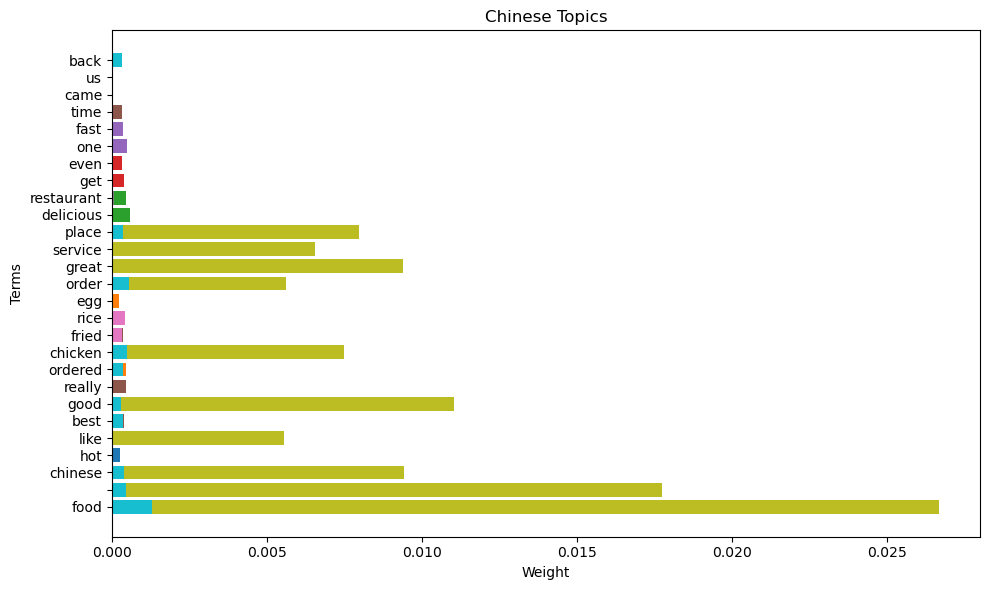

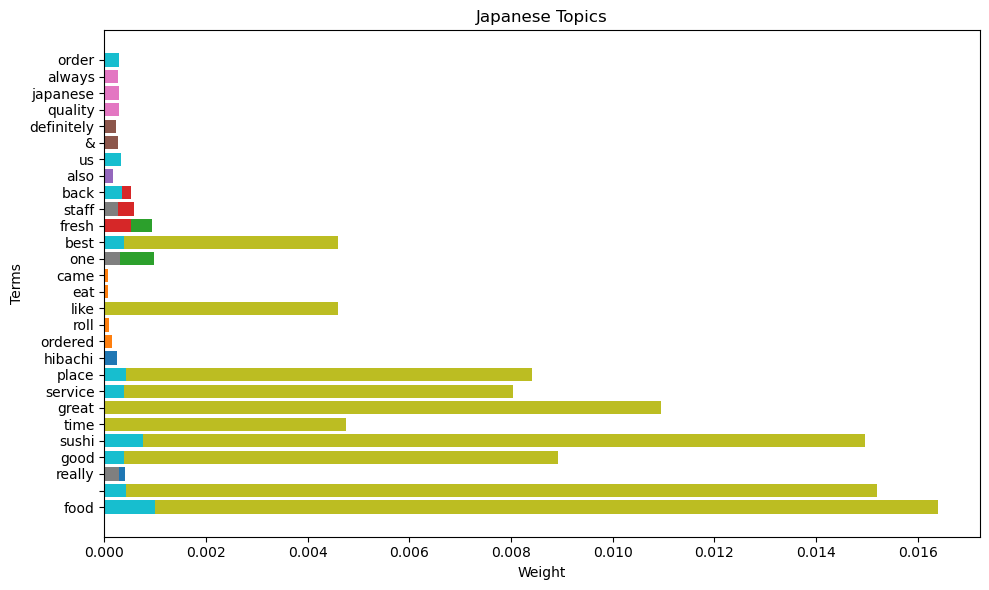

In [29]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, StringType
import numpy as np
import matplotlib.pyplot as plt

# Function to map term indices to words
def map_indices_to_words(indices):
    return [vocab[i] for i in indices]

# Register the UDF
map_indices_udf = udf(map_indices_to_words, ArrayType(StringType()))

# Apply the UDF to map term indices to words for both Chinese and Japanese topics
topics_chinese_with_words = topics_chinese.withColumn("terms", map_indices_udf(col("termIndices")))
topics_japanese_with_words = topics_japanese.withColumn("terms", map_indices_udf(col("termIndices")))

# Collect the results into a Pandas DataFrame for easier plotting
chinese_topics_data = topics_chinese_with_words.select("topic", "terms", "termWeights").collect()
japanese_topics_data = topics_japanese_with_words.select("topic", "terms", "termWeights").collect()

# Function to filter out topics with empty or unwanted terms
def filter_empty_terms(topic_data):
    filtered_data = []
    for topic_row in topic_data:
        terms = topic_row['terms']
        # Filter out topics that have empty or just unwanted characters
        if any(term != "" and term != "&" for term in terms):
            filtered_data.append(topic_row)
    return filtered_data

# Filter out unwanted topics
chinese_topics_data_filtered = filter_empty_terms(chinese_topics_data)
japanese_topics_data_filtered = filter_empty_terms(japanese_topics_data)

# Function to plot topics
def plot_topic_terms(topic_data, title="Topic Terms"):
    fig, ax = plt.subplots(figsize=(10, 6))

    for topic_row in topic_data:
        terms = topic_row['terms']  # List of terms for a topic
        weights = topic_row['termWeights']  # List of term weights for a topic
        
        # Sort terms by weight
        sorted_indices = np.argsort(weights)[::-1]
        sorted_terms = [terms[i] for i in sorted_indices]
        sorted_weights = [weights[i] for i in sorted_indices]
        
        # Plot top 10 terms
        ax.barh(sorted_terms[:10], sorted_weights[:10], label=f"Topic {topic_row['topic']}")

    ax.set_title(title)
    ax.set_xlabel("Weight")
    ax.set_ylabel("Terms")
    plt.tight_layout()

    # Save the plot to a PNG file
    plt.savefig('topic_terms_filtered.png')
    plt.show()

# Plot for Chinese topics
plot_topic_terms(chinese_topics_data_filtered, title="Chinese Topics")

# Plot for Japanese topics
plot_topic_terms(japanese_topics_data_filtered, title="Japanese Topics")


Skipping topic 0 due to mismatch in terms and weights length
Skipping topic 1 due to mismatch in terms and weights length
Skipping topic 2 due to mismatch in terms and weights length
Skipping topic 3 due to mismatch in terms and weights length
Skipping topic 4 due to mismatch in terms and weights length
Skipping topic 5 due to mismatch in terms and weights length
Skipping topic 6 due to mismatch in terms and weights length
Skipping topic 8 due to mismatch in terms and weights length
Skipping topic 9 due to mismatch in terms and weights length
Skipping topic 0 due to mismatch in terms and weights length
Skipping topic 1 due to mismatch in terms and weights length
Skipping topic 2 due to mismatch in terms and weights length
Skipping topic 3 due to mismatch in terms and weights length
Skipping topic 4 due to mismatch in terms and weights length
Skipping topic 5 due to mismatch in terms and weights length
Skipping topic 6 due to mismatch in terms and weights length
Skipping topic 8 due to 

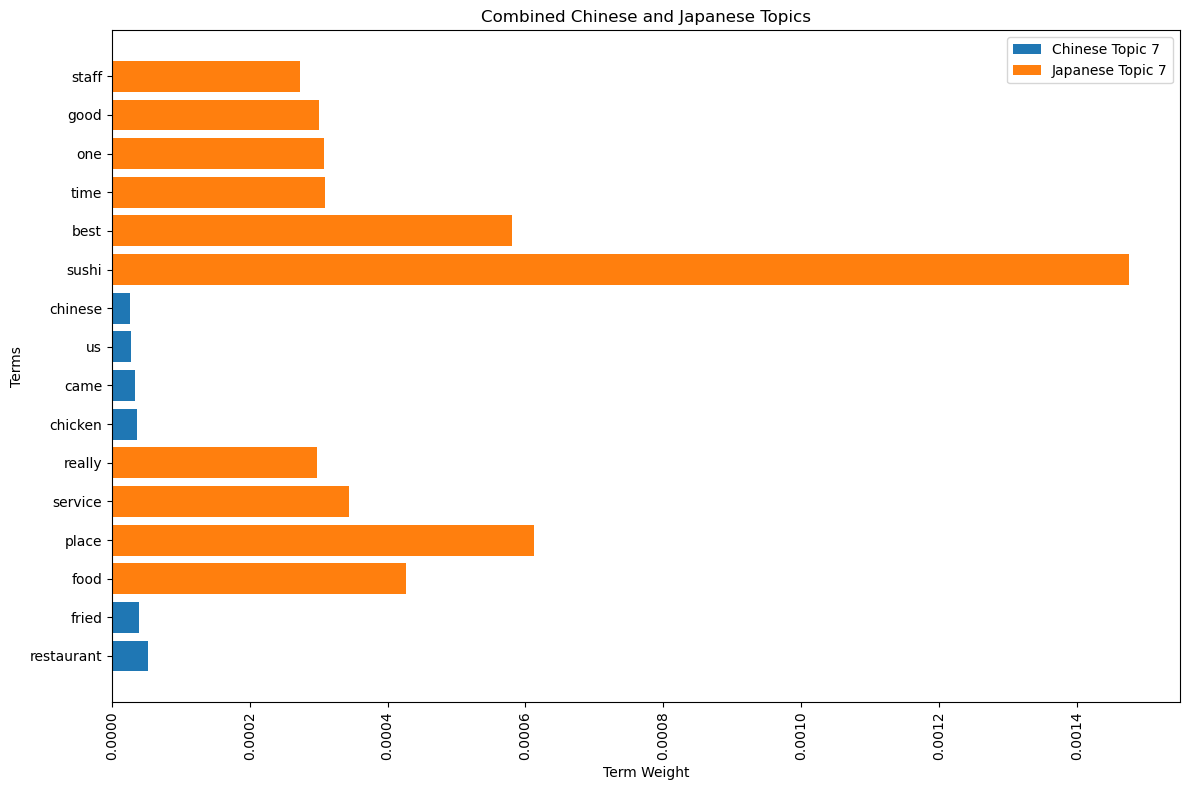

In [38]:
from pyspark.sql import Row
import numpy as np
import matplotlib.pyplot as plt

# Function to filter out empty or unwanted terms (e.g., empty strings or "&")
def filter_empty_terms(topic_data):
    filtered_data = []
    for topic_row in topic_data:
        # Convert Row object to dictionary
        topic_dict = topic_row.asDict()
        
        # Filter out terms that are empty or just "&"
        terms = topic_dict['terms']
        valid_terms = [term for term in terms if term != "" and term != "&"]
        
        # Only add to filtered list if there are valid terms
        if valid_terms:
            topic_dict['terms'] = valid_terms  # Update the dictionary with valid terms
            filtered_data.append(Row(**topic_dict))  # Create a new Row with updated data
    
    return filtered_data

# Filter out unwanted terms for both Chinese and Japanese topics
chinese_topics_data_filtered = filter_empty_terms(chinese_topics_data)
japanese_topics_data_filtered = filter_empty_terms(japanese_topics_data)

# Function to plot topics with top terms and weights
def plot_combined_topic_terms(topic_data_chinese, topic_data_japanese, title="Combined Chinese and Japanese Topics", num_terms=20):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot Chinese topics
    for topic_row in topic_data_chinese:
        terms = topic_row['terms']
        weights = topic_row['termWeights']

        # Check if terms and weights are the same length
        if len(terms) != len(weights):
            print(f"Skipping topic {topic_row['topic']} due to mismatch in terms and weights length")
            continue

        # Sort terms by weight and select top N terms, avoiding index errors
        sorted_indices = np.argsort(weights)[::-1]
        sorted_terms = [terms[i] for i in sorted_indices]
        sorted_weights = [weights[i] for i in sorted_indices]

        # Use the minimum of num_terms or the length of terms
        ax.barh(sorted_terms[:min(num_terms, len(sorted_terms))], sorted_weights[:min(num_terms, len(sorted_weights))], label=f"Chinese Topic {topic_row['topic']}")

    # Plot Japanese topics
    for topic_row in topic_data_japanese:
        terms = topic_row['terms']
        weights = topic_row['termWeights']

        # Check if terms and weights are the same length
        if len(terms) != len(weights):
            print(f"Skipping topic {topic_row['topic']} due to mismatch in terms and weights length")
            continue

        # Sort terms by weight and select top N terms, avoiding index errors
        sorted_indices = np.argsort(weights)[::-1]
        sorted_terms = [terms[i] for i in sorted_indices]
        sorted_weights = [weights[i] for i in sorted_indices]

        # Use the minimum of num_terms or the length of terms
        ax.barh(sorted_terms[:min(num_terms, len(sorted_terms))], sorted_weights[:min(num_terms, len(sorted_weights))], label=f"Japanese Topic {topic_row['topic']}")

    # Set the title, labels, and display the plot
    ax.set_title(title)
    ax.set_xlabel("Term Weight")
    ax.set_ylabel("Terms")
    plt.xticks(rotation=90)
    plt.tight_layout()

    # Add a legend
    plt.legend()

    # Save the plot as a PNG file
    plt.savefig('combined_topic_terms_dot_graph.png')
    plt.show()

# Plot combined topics for both Chinese and Japanese topics
plot_combined_topic_terms(chinese_topics_data_filtered, japanese_topics_data_filtered, title="Combined Chinese and Japanese Topics", num_terms=20)


Skipping topic 0 due to mismatch in terms and weights length
Skipping topic 1 due to mismatch in terms and weights length
Skipping topic 2 due to mismatch in terms and weights length
Skipping topic 3 due to mismatch in terms and weights length
Skipping topic 4 due to mismatch in terms and weights length
Skipping topic 5 due to mismatch in terms and weights length
Skipping topic 6 due to mismatch in terms and weights length
Skipping topic 8 due to mismatch in terms and weights length
Skipping topic 9 due to mismatch in terms and weights length
Skipping topic 0 due to mismatch in terms and weights length
Skipping topic 1 due to mismatch in terms and weights length
Skipping topic 2 due to mismatch in terms and weights length
Skipping topic 3 due to mismatch in terms and weights length
Skipping topic 4 due to mismatch in terms and weights length
Skipping topic 5 due to mismatch in terms and weights length
Skipping topic 6 due to mismatch in terms and weights length
Skipping topic 8 due to 

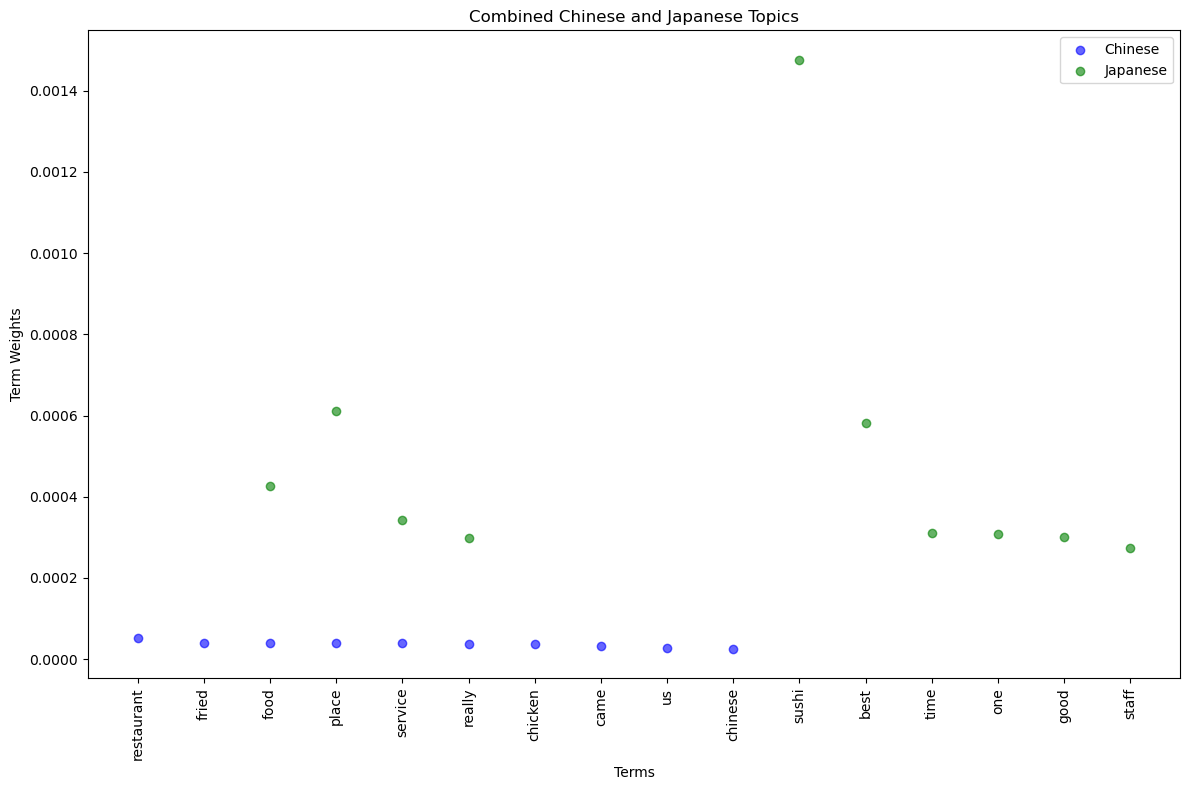

In [39]:
from pyspark.sql import Row
import numpy as np
import matplotlib.pyplot as plt

# function to filter out empty or unwanted terms (e.g., empty strings or "&")
def filter_empty_terms(topic_data):
    filtered_data = []
    for topic_row in topic_data:
        # convert to dictionary
        topic_dict = topic_row.asDict()
        
        # filter out terms that are empty or meaningless
        terms = topic_dict['terms']
        valid_terms = [term for term in terms if term != "" and term != "&"]
        
        # only add to filtered list if there are valid terms
        if valid_terms:
            topic_dict['terms'] = valid_terms  # Update the dictionary with valid terms
            filtered_data.append(Row(**topic_dict))  # Create a new Row with updated data
    
    return filtered_data

# Filter out unwanted terms for both Chinese and Japanese topics
chinese_topics_data_filtered = filter_empty_terms(chinese_topics_data)
japanese_topics_data_filtered = filter_empty_terms(japanese_topics_data)

# Function to plot combined topics with dot graphs
def plot_combined_topic_terms_dot_graph(topic_data_chinese, topic_data_japanese, title="Combined Chinese and Japanese Topics", num_terms=20):
    # Prepare data for plotting
    topic_labels = []
    topic_weights = []
    topic_languages = []  # For color differentiation (Chinese vs. Japanese)

    for topic_data, language in zip([topic_data_chinese, topic_data_japanese], ['Chinese', 'Japanese']):
        for topic_row in topic_data:
            terms = topic_row['terms']
            weights = topic_row['termWeights']
            
            # Check if terms and weights are the same length
            if len(terms) != len(weights):
                print(f"Skipping topic {topic_row['topic']} due to mismatch in terms and weights length")
                continue

            # Sort terms by weight and select top N terms, avoiding index errors
            sorted_indices = np.argsort(weights)[::-1]
            sorted_terms = [terms[i] for i in sorted_indices]
            sorted_weights = [weights[i] for i in sorted_indices]
            
            # Use the minimum of num_terms or the length of terms
            topic_labels.extend(sorted_terms[:min(num_terms, len(sorted_terms))])  # Use top N terms
            topic_weights.extend(sorted_weights[:min(num_terms, len(sorted_weights))])  # Use top N weights
            topic_languages.extend([language] * min(num_terms, len(sorted_terms)))  # Add the language (Chinese/Japanese)

    # Create the scatter plot (dot graph)
    plt.figure(figsize=(12, 8))

    # Different colors for Chinese and Japanese topics
    colors = {'Chinese': 'blue', 'Japanese': 'green'}
    for language in set(topic_languages):
        language_indices = [i for i, lang in enumerate(topic_languages) if lang == language]
        plt.scatter(np.array(topic_labels)[language_indices], 
                    np.array(topic_weights)[language_indices], 
                    color=colors[language], label=language, alpha=0.6)

    plt.title(title)
    plt.xlabel('Terms')
    plt.ylabel('Term Weights')
    plt.xticks(rotation=90)  # Rotate term labels for better readability
    plt.tight_layout()

    # Add a legend
    plt.legend()


    plt.savefig('combined_topic_terms_dot_graph.png')
    plt.show()


plot_combined_topic_terms_dot_graph(chinese_topics_data_filtered, japanese_topics_data_filtered, title="Combined Chinese and Japanese Topics", num_terms=20)


In [8]:
# Transform Chinese reviews with LDA model
chinese_lda_transformed = lda_chinese_model.transform(chinese_reviews)
chinese_lda_transformed.select("text", "topicDistribution").show(truncate=False)

# Transform Japanese reviews with LDA model
japanese_lda_transformed = lda_japanese_model.transform(japanese_reviews)
japanese_lda_transformed.select("text", "topicDistribution").show(truncate=False)


24/12/07 02:33:05 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
24/12/07 02:33:05 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
24/12/07 02:33:06 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
# word embedding
from pyspark.ml.feature import Word2Vec

# Train Word2Vec for Chinese reviews
word2vec_chinese = Word2Vec(vectorSize=100, inputCol="filtered_words", outputCol="sentence_vectors")
model_chinese = word2vec_chinese.fit(chinese_reviews)
chinese_vectors = model_chinese.transform(chinese_reviews)

# Train Word2Vec for Japanese reviews
word2vec_japanese = Word2Vec(vectorSize=100, inputCol="filtered_words", outputCol="sentence_vectors")
model_japanese = word2vec_japanese.fit(japanese_reviews)
japanese_vectors = model_japanese.transform(japanese_reviews)


In [62]:
# high dimension: reduce
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col

# Perform PCA on Chinese word vectors
pca_chinese = PCA(k=12, inputCol="sentence_vectors", outputCol="pca_features_chinese")
pca_chinese_model = pca_chinese.fit(chinese_vectors)
chinese_pca_result = pca_chinese_model.transform(chinese_vectors)

# Perform PCA on Japanese word vectors
pca_japanese = PCA(k=12, inputCol="sentence_vectors", outputCol="pca_features_japanese")
pca_japanese_model = pca_japanese.fit(japanese_vectors)
japanese_pca_result = pca_japanese_model.transform(japanese_vectors)

# Show the resulting principal components
chinese_pca_result.select("pca_features_chinese").show(5, truncate=False)
japanese_pca_result.select("pca_features_japanese").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|pca_features_chinese                                                                                                                                                                                                                                        |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-0.06869081326585871,0.15040294387371228,-1.2992806579805935E-4,-0.08810088630529778,0.013252381067542451,0.007755832698732708,-0.032596687682048445,-0.04241483215816612,-0.02517440284563993,0.03991520610323153,0.03305476736766233,0.

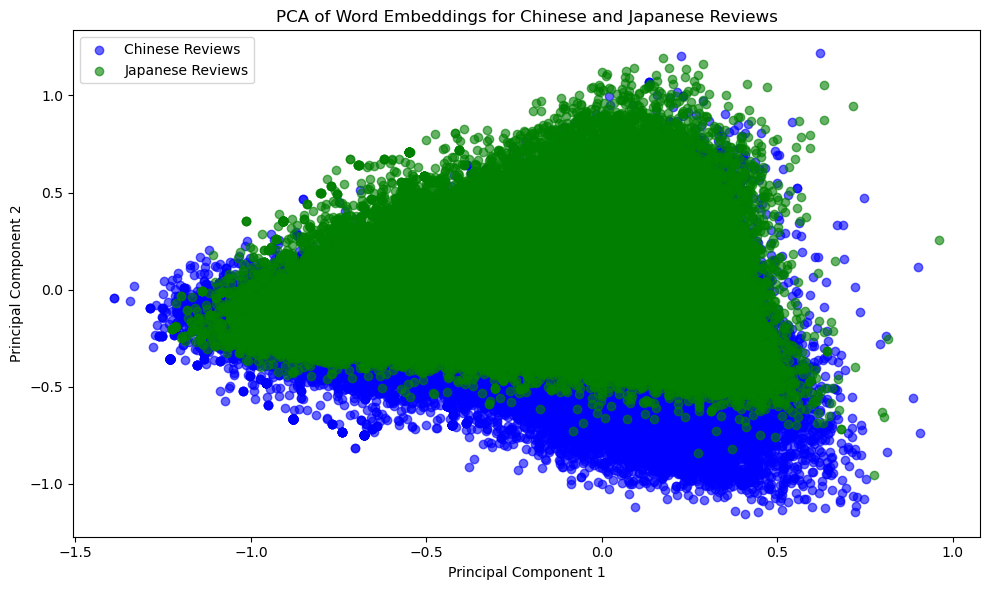

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Collect PCA results into pandas DataFrame for plotting
chinese_pca_data = chinese_pca_result.select("pca_features_chinese").rdd.map(lambda row: row[0].toArray()).collect()
japanese_pca_data = japanese_pca_result.select("pca_features_japanese").rdd.map(lambda row: row[0].toArray()).collect()

# Convert data to numpy arrays for plotting
chinese_pca_data = np.array(chinese_pca_data)
japanese_pca_data = np.array(japanese_pca_data)

# Plot the PCA results
plt.figure(figsize=(10, 6))

# Plot Chinese data points
plt.scatter(chinese_pca_data[:, 0], chinese_pca_data[:, 1], color='blue', label='Chinese Reviews', alpha=0.6)

# Plot Japanese data points
plt.scatter(japanese_pca_data[:, 0], japanese_pca_data[:, 1], color='green', label='Japanese Reviews', alpha=0.6)

plt.title('PCA of Word Embeddings for Chinese and Japanese Reviews')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('pca_visualization.png')
plt.show()


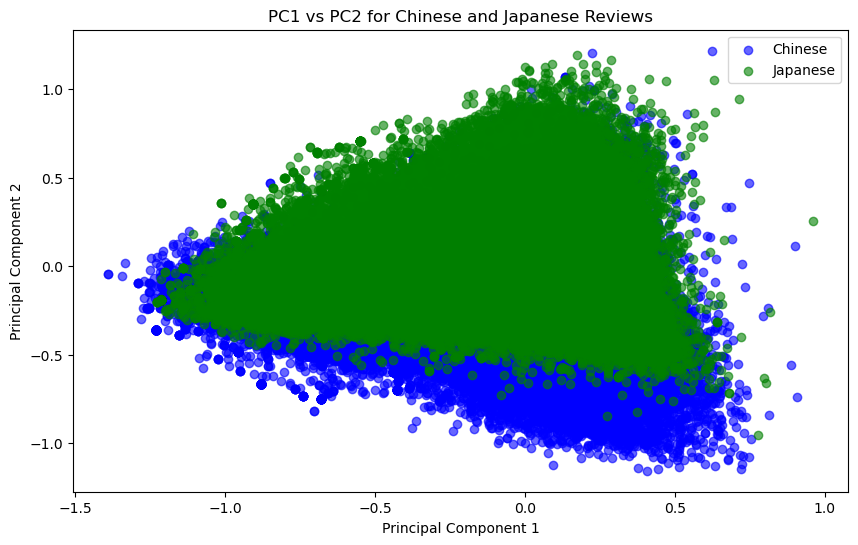

In [47]:
#help of chatgpt ploting
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Collect PCA results for Chinese and Japanese data
chinese_pca_data = chinese_pca_result.select("pca_features_chinese").rdd.map(lambda row: row[0]).collect()
japanese_pca_data = japanese_pca_result.select("pca_features_japanese").rdd.map(lambda row: row[0]).collect()

# Convert the PCA results to a list of tuples (PC1, PC2)
chinese_pca_pc1_pc2 = [(vec[0], vec[1]) for vec in chinese_pca_data]  # PC1, PC2 for Chinese
japanese_pca_pc1_pc2 = [(vec[0], vec[1]) for vec in japanese_pca_data]  # PC1, PC2 for Japanese

# Plot PC1 vs PC2 for both Chinese and Japanese
plt.figure(figsize=(10, 6))
plt.scatter([x[0] for x in chinese_pca_pc1_pc2], [x[1] for x in chinese_pca_pc1_pc2], color='blue', label='Chinese', alpha=0.6)
plt.scatter([x[0] for x in japanese_pca_pc1_pc2], [x[1] for x in japanese_pca_pc1_pc2], color='green', label='Japanese', alpha=0.6)
plt.title("PC1 vs PC2 for Chinese and Japanese Reviews")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()



In [52]:
from pyspark.ml.feature import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

# Fit the model
vectorized_model = vectorizer.fit(df_filtered)

# Transform the dataframe using the fitted model
df_bow = vectorized_model.transform(df_filtered)

# Now, you can safely use the vectorized_model
vocab = vectorized_model.vocabulary  # This should work now


In [54]:
from pyspark.ml.linalg import Vectors

# Show the PCA results for Chinese and Japanese reviews
chinese_pca_result.select("pca_features_chinese").show(5, truncate=False)
japanese_pca_result.select("pca_features_japanese").show(5, truncate=False)


+-----------------------------------------------------------------+
|pca_features_chinese                                             |
+-----------------------------------------------------------------+
|[-0.06869081326585871,0.15040294387371228,-1.2992806579806108E-4]|
|[0.09699145971015283,0.07664532451063001,0.005404960502988876]   |
|[-0.6845351725556087,-0.06067637447820477,0.02356618503177596]   |
|[-0.34635961646926494,-0.17539729773368498,-0.14269745463576047] |
|[0.2376236970564864,0.03578260412017344,-0.04091840264410107]    |
+-----------------------------------------------------------------+
only showing top 5 rows

+----------------------------------------------------------------+
|pca_features_japanese                                           |
+----------------------------------------------------------------+
|[0.030166684451882128,0.3395030681108873,-0.13215097958254163]  |
|[-0.1052451925082032,0.13230504375828278,-0.06444150839160988]  |
|[-0.1251269772519719,-0.111

In [55]:
# Collect the PCA results for Chinese and Japanese
chinese_pca_data = chinese_pca_result.select("pca_features_chinese").rdd.map(lambda row: row[0]).collect()
japanese_pca_data = japanese_pca_result.select("pca_features_japanese").rdd.map(lambda row: row[0]).collect()

# Print out the first 5 rows of the PCA features (PC1 and PC2)
print("Chinese PCA components (PC1 and PC2):")
for row in chinese_pca_data[:5]:
    print(row)  # show the values of PC1, PC2, and other components

print("Japanese PCA components (PC1 and PC2):")
for row in japanese_pca_data[:5]:
    print(row)


Chinese PCA components (PC1 and PC2):
[-0.06869081326585871,0.15040294387371228,-0.00012992806579806108]
[0.09699145971015283,0.07664532451063001,0.005404960502988876]
[-0.6845351725556087,-0.06067637447820477,0.02356618503177596]
[-0.34635961646926494,-0.17539729773368498,-0.14269745463576047]
[0.2376236970564864,0.03578260412017344,-0.04091840264410107]
Japanese PCA components (PC1 and PC2):
[0.030166684451882128,0.3395030681108873,-0.13215097958254163]
[-0.1052451925082032,0.13230504375828278,-0.06444150839160988]
[-0.1251269772519719,-0.11174170350745102,-0.12976944638467597]
[-0.18318176696881733,-0.15821838188141052,-0.05502320550893692]
[-0.17884949514442702,0.24759011982602325,-0.0961814496434144]


In [59]:
# Get the vocabulary (terms) associated with each word vector
vocab_chinese = model_chinese.getVectors().rdd.map(lambda row: row[0]).collect()  # Vocabulary for Chinese reviews
vocab_japanese = model_japanese.getVectors().rdd.map(lambda row: row[0]).collect()  # Vocabulary for Japanese reviews


24/12/07 03:31:59 WARN TaskSetManager: Stage 363 contains a task of very large size (2989 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 03:32:00 WARN TaskSetManager: Stage 364 contains a task of very large size (3464 KiB). The maximum recommended task size is 1000 KiB.


In [64]:
# extract PCA components (PC1, PC2)
pca_chinese_components = pca_chinese_model.pc.toArray()  # Components for Chinese reviews
pca_japanese_components = pca_japanese_model.pc.toArray()  # Components for Japanese reviews

# map the components to terms in the vocabulary (assuming you have vocabulary for Chinese and Japanese)
# make sure to match each term's weight with its corresponding term
vocab_chinese = model_chinese.getVectors().rdd.map(lambda row: row[0]).collect()  # Vocabulary for Chinese reviews
vocab_japanese = model_japanese.getVectors().rdd.map(lambda row: row[0]).collect()  # Vocabulary for Japanese reviews

# For each PCA component, you can use the term weights to understand which words are most influential in defining PC1 and PC2.
def get_top_terms_for_component(pca_components, terms, num_top_terms=10):
    # Get the top terms that most influence the first principal component (PC1) and second principal component (PC2)
    top_terms_pc1 = sorted(zip(pca_components[0], terms), key=lambda x: abs(x[0]), reverse=True)[:num_top_terms]
    top_terms_pc2 = sorted(zip(pca_components[1], terms), key=lambda x: abs(x[0]), reverse=True)[:num_top_terms]
    
    return top_terms_pc1, top_terms_pc2

# Get the top terms for Chinese PCA components
top_terms_chinese_pc1, top_terms_chinese_pc2 = get_top_terms_for_component(pca_chinese_components, vocab_chinese)

# Get the top terms for Japanese PCA components
top_terms_japanese_pc1, top_terms_japanese_pc2 = get_top_terms_for_component(pca_japanese_components, vocab_japanese)

# Display the top terms for each component
print("Top terms for PC1 and PC2 in Chinese:")
print("PC1:", top_terms_chinese_pc1)
print("PC2:", top_terms_chinese_pc2)

print("Top terms for PC1 and PC2 in Japanese:")
print("PC1:", top_terms_japanese_pc1)
print("PC2:", top_terms_japanese_pc2)



24/12/07 03:38:55 WARN TaskSetManager: Stage 397 contains a task of very large size (2989 KiB). The maximum recommended task size is 1000 KiB.


24/12/07 03:38:55 WARN TaskSetManager: Stage 398 contains a task of very large size (3464 KiB). The maximum recommended task size is 1000 KiB.
Top terms for PC1 and PC2 in Chinese:
PC1: [(-0.1930310992985305, 'incident'), (-0.176710521667364, 'cook...'), (0.11386659247352054, 'customers..'), (0.10692493150192883, 'serious'), (-0.07717122145099145, 'eaten,'), (0.06944748110839259, 'again!!!'), (0.06326719686261001, 'maintained,'), (-0.0620313603821131, 'specifically,'), (0.055469053366387695, 'buns'), (0.04292435196086891, '$100+')]
PC2: [(0.07292682032734343, 'specifically,'), (-0.07181929326456851, 'echo.'), (-0.0714081288534298, 'serious'), (-0.05807300238034137, '$100+'), (0.0562071034186648, 'buns'), (-0.04804467153633857, 'customers..'), (0.03592310347696681, 'incident'), (-0.03584143402618545, 'herself.'), (-0.028647121909895892, 'eaten,'), (-0.022090912546652075, 'cook...')]
Top terms for PC1 and PC2 in Japanese:
PC1: [(0.21140970555151734, 'buns'), (0.17192321730499255, 'sake).